In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Import data from CSV, drop unessecary columns, convert integer values to text for categorical values as specified in the dictionary.txt associated with this dataset. Create mask to isolate only rows that contain information regarding an attempt on goal

In [2]:
events_df = pd.read_csv('Downloads/events.csv')

In [3]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

In [4]:
events_df.drop(columns=['id_odsp','id_event', 'sort_order', 'text', 'player_in', 'player_out'], inplace=True)
events_df.head(5)

,time,event_type,event_type2,side,event_team,opponent,player,player2,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,2,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,6.0,2.0,0,9.0,2.0,1,1.0,0
1,4,2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,0,NaN,NaN,0,NaN,0
2,4,2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,0,NaN,NaN,0,NaN,0
3,7,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,7,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [5]:
events_df.loc[:, 'shot_outcome'].replace({1: 'On target', 2: 'Off target', 3: 'Blocked', 4: 'Hit the bar'},\
                                         inplace=True)
events_df.loc[:, 'shot_place'].replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner',\
                                       5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left',\
                                       9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', 12: 'Top left corner',\
                                       13: 'Top right corner'}, inplace=True)
events_df.loc[:, 'location'].replace({1: 'Attacking half', 2: 'Defensive half', 3: 'Centre of the box', 4: 'Left wing',\
                                       5: 'Right wing', 6: 'Difficult angle and long range', 7: 'Difficult angle on the left', 8: 'Difficult angle on the right',\
                                       9: 'Left side of the box', 10: 'Left side of the six yard box', 11: 'Right side of the box', 12: 'Right side of the six yard box',\
                                       13: 'Very close range', 14: 'Penalty spot', 15: 'Outside the box', 16: 'Long range',\
                                      17: 'More than 35 yards', 18: 'More than 40 yards', 19: 'Not recorded'}, inplace=True)
events_df.loc[:, 'bodypart'].replace({1: 'right foot', 2: 'left foot', 3: 'head'},\
                                         inplace=True)
events_df.loc[:, 'assist_method'].replace({0: 'None', 1: 'Pass', 2: 'Cross', 3: 'Headed pass', 4: 'Through ball'},\
                                         inplace=True)
events_df.loc[:, 'situation'].replace({1: 'Open play', 2: 'Set piece', 3: 'Corner', 4: 'Free kick'},\
                                         inplace=True)
events_df.head()

,time,event_type,event_type2,side,event_team,opponent,player,player2,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,2,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,High and wide,Off target,0,Left side of the box,left foot,Pass,Open play,0
1,4,2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,0,NaN,NaN,None,NaN,0
2,4,2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,0,NaN,NaN,None,NaN,0
3,7,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,0,NaN,NaN,None,NaN,0
4,7,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,0,Defensive half,NaN,None,NaN,0


In [6]:
mask = (events_df['event_type']==1)
all_attempts = events_df.loc[mask]
all_attempts.head()

,time,event_type,event_type2,side,event_team,opponent,player,player2,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,2,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,High and wide,Off target,0,Left side of the box,left foot,Pass,Open play,0
11,14,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,mario gotze,Top right corner,Off target,0,Outside the box,right foot,Pass,Open play,0
13,17,1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,Bottom right corner,On target,1,Left side of the box,left foot,Pass,Open play,0
14,19,1,NaN,1,Borussia Dortmund,Hamburg SV,mats hummels,NaN,Blocked,Blocked,0,Outside the box,right foot,None,Open play,0
17,20,1,NaN,2,Hamburg SV,Borussia Dortmund,tomas rincon,NaN,Blocked,Blocked,0,Outside the box,right foot,None,Open play,0


In [7]:
all_attempts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229135 entries, 0 to 941006
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           229135 non-null  int64  
 1   event_type     229135 non-null  int64  
 2   event_type2    168560 non-null  float64
 3   side           229135 non-null  int64  
 4   event_team     229135 non-null  object 
 5   opponent       229135 non-null  object 
 6   player         229122 non-null  object 
 7   player2        167798 non-null  object 
 8   shot_place     227452 non-null  object 
 9   shot_outcome   228498 non-null  object 
 10  is_goal        229135 non-null  int64  
 11  location       229135 non-null  object 
 12  bodypart       229135 non-null  object 
 13  assist_method  229135 non-null  object 
 14  situation      229135 non-null  object 
 15  fast_break     229135 non-null  int64  
dtypes: float64(1), int64(5), object(10)
memory usage: 29.7+ MB


### Dropping rows with NaN values in shot_outcome, shot_place, and player so all data points are evaluated similarly. Not all shot attempts are assisted, so NaN is a viable value in event_type2. Additionally removing rows where location was unavailable 

In [8]:
cleaned_att = all_attempts.dropna(subset=['shot_outcome', 'shot_place', 'player'])
cleaned_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227451 entries, 0 to 941006
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           227451 non-null  int64  
 1   event_type     227451 non-null  int64  
 2   event_type2    167193 non-null  float64
 3   side           227451 non-null  int64  
 4   event_team     227451 non-null  object 
 5   opponent       227451 non-null  object 
 6   player         227451 non-null  object 
 7   player2        167080 non-null  object 
 8   shot_place     227451 non-null  object 
 9   shot_outcome   227451 non-null  object 
 10  is_goal        227451 non-null  int64  
 11  location       227451 non-null  object 
 12  bodypart       227451 non-null  object 
 13  assist_method  227451 non-null  object 
 14  situation      227451 non-null  object 
 15  fast_break     227451 non-null  int64  
dtypes: float64(1), int64(5), object(10)
memory usage: 29.5+ MB


In [19]:
cleaned_att.to_csv('cleaned_att.csv')

In [4]:
cleaned_att = pd.read_csv('cleaned_att.csv')
cleaned_att.drop(columns= 'Unnamed: 0', inplace=True)
cleaned_att.drop(cleaned_att[cleaned_att.location == 'Not recorded'].index, inplace=True)
cleaned_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226676 entries, 0 to 227450
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           226676 non-null  int64  
 1   event_type     226676 non-null  int64  
 2   event_type2    167141 non-null  float64
 3   side           226676 non-null  int64  
 4   event_team     226676 non-null  object 
 5   opponent       226676 non-null  object 
 6   player         226676 non-null  object 
 7   player2        167080 non-null  object 
 8   shot_place     226676 non-null  object 
 9   shot_outcome   226676 non-null  object 
 10  is_goal        226676 non-null  int64  
 11  location       226676 non-null  object 
 12  bodypart       226676 non-null  object 
 13  assist_method  226676 non-null  object 
 14  situation      226676 non-null  object 
 15  fast_break     226676 non-null  int64  
dtypes: float64(1), int64(5), object(10)
memory usage: 29.4+ MB


0    0.902967
1    0.097033
Name: is_goal, dtype: float64


Text(0.5, 1.0, 'class distribution')

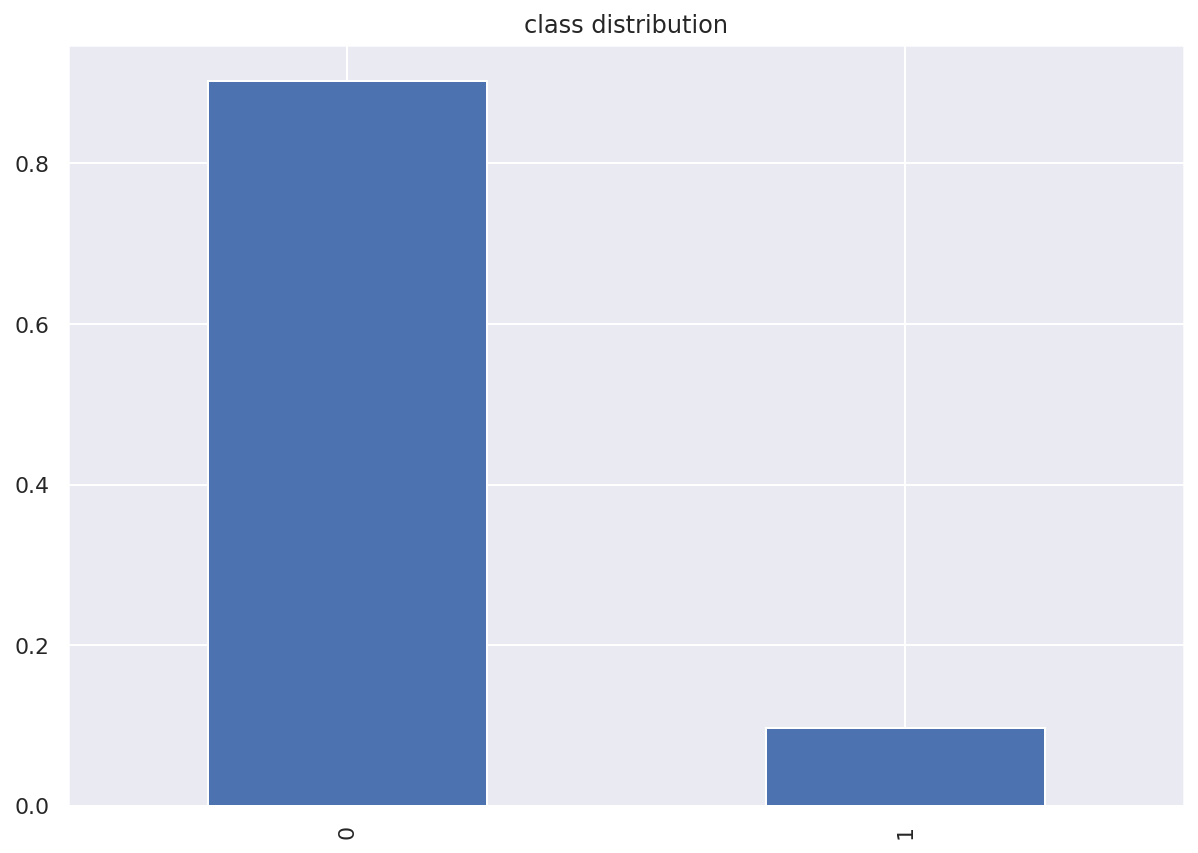

In [27]:
target_pcts = cleaned_att.is_goal.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')
plt.title('class distribution')

starting with logistic regression

In [5]:
columns=['time','side','shot_place','shot_outcome','location','bodypart','assist_method','situation','fast_break']
X = cleaned_att.loc[:, columns]
y = cleaned_att['is_goal']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=9)

In [113]:
lr = LogisticRegression(solver='lbfgs', max_iter=5000)
lr.fit(pd.get_dummies(X_train), y_train)
y_pred = lr.predict(pd.get_dummies(X_val))
f1_score(y_val, y_pred)

0.6576016576016576

In [114]:
lr.coef_

array([[ 3.25046908e-04, -6.00345284e-02,  6.14505852e+00,
        -4.19044555e-01, -1.00011946e+00,  1.95537942e+00,
         1.84657627e+00,  5.32610234e-01, -6.01203100e-01,
        -1.97709602e+00, -9.57594947e-01, -9.22159157e-01,
        -7.89773535e-01, -4.05890623e+00,  2.27099483e+00,
         2.35526452e+00, -1.00011946e+00, -1.97709602e+00,
        -5.05703296e+00,  6.26917670e+00,  1.36446520e+00,
        -1.25631075e+00, -1.04749019e-01, -2.51694662e-01,
        -1.03764519e-01,  1.49703044e+00, -1.51833027e+00,
        -1.26109046e+00, -1.29331190e+00, -5.76409608e-01,
        -2.98287905e+00,  1.57651548e-02,  1.60583797e+00,
         3.10036974e+00, -1.26543804e+00, -2.61880593e-01,
        -2.37753098e-01, -4.45873530e-01, -6.43048511e-01,
        -3.98295297e-01, -4.07765643e-01,  1.29911248e-01,
         1.87482923e+00, -1.93010601e-01, -4.76768975e+00,
         1.32079939e+00]])

In [115]:
scores = cross_val_score(lr, pd.get_dummies(X_tr), y_tr, cv=10, scoring='f1')
print(scores)

[0.66491631 0.63901203 0.675      0.64107612 0.65308804 0.67522465
 0.65957447 0.65831135 0.66644993 0.65831728]


In [116]:
scores.mean()
#.657 and .659 gives a good indicator that the model is well fit, and not overfitting the training set.

0.6590970174103169

Text(0.5, 1.0, 'lr confusion matrix')

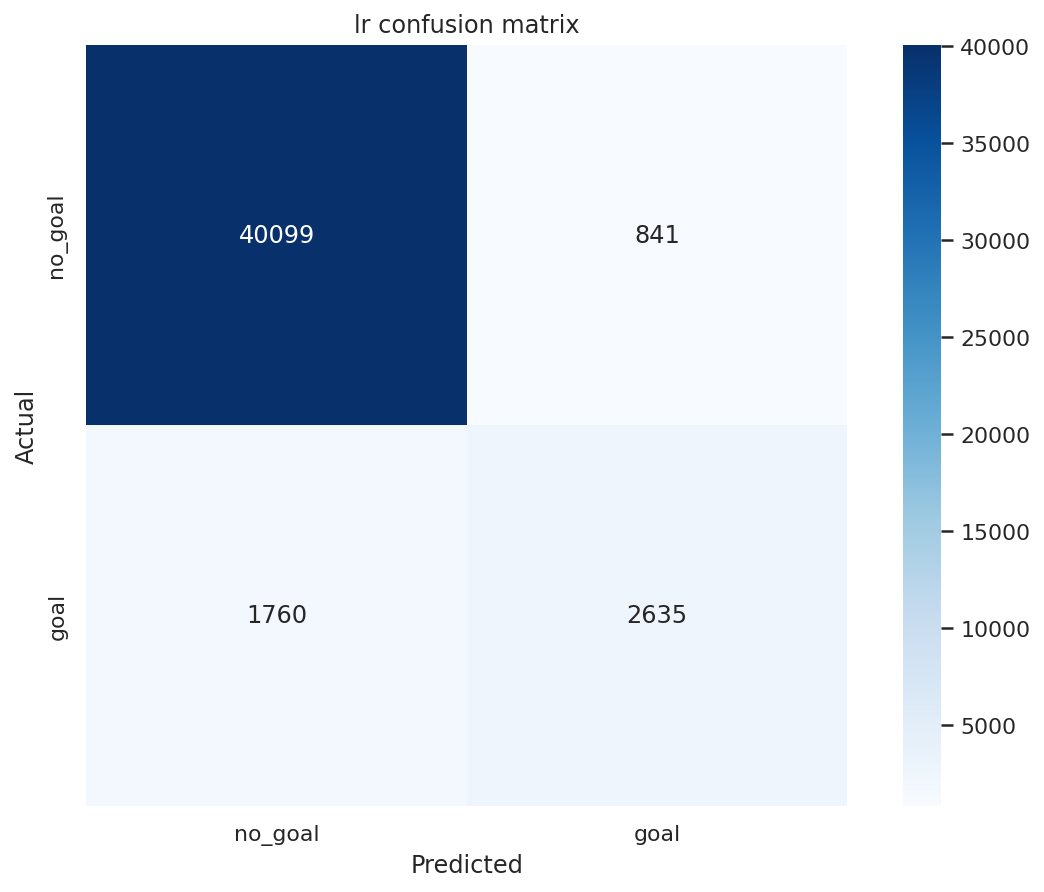

In [39]:
from sklearn.metrics import confusion_matrix

lr_confusion = confusion_matrix(y_val, y_pred)
lr_confusion
sns.heatmap(lr_confusion, cmap=plt.cm.Blues,fmt='d', annot=True, square=True,
           xticklabels=['no_goal','goal'],
           yticklabels=['no_goal','goal']);

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('lr confusion matrix')

In [118]:
from sklearn.inspection import permutation_importance
lr.fit(pd.get_dummies(X_train), y_train)
lr_features_imp = permutation_importance(lr, pd.get_dummies(X_val), y_val, scoring = 'f1', n_jobs = -1)

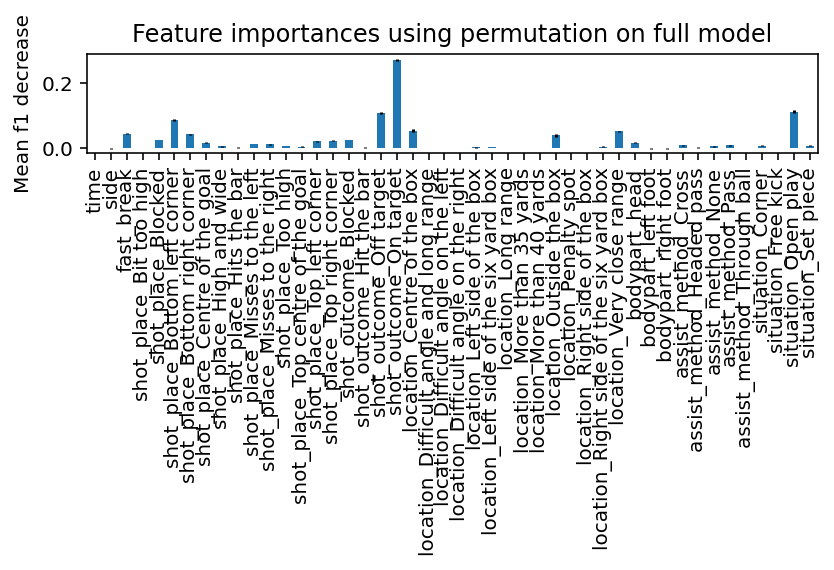

In [119]:
lr_importances = pd.Series(lr_features_imp.importances_mean, index=pd.get_dummies(X_train).columns)

fig, ax = plt.subplots()
lr_importances.plot.bar(yerr=lr_features_imp.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean f1 decrease")
fig.tight_layout()
plt.show()

In [120]:
log_loss(y_val, lr.predict_proba(pd.get_dummies(X_val)))

0.1284873589853657

### Same data, but with KNN model

In [27]:
knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(pd.get_dummies(X_train), y_train)
ky_pred = knn.predict(pd.get_dummies(X_val))

print(metrics.f1_score(y_val, ky_pred))
#n=10 was .5078

0.47648902821316613


In [18]:
k_range = list(range(1, 25))
k_scores = []
X_dum = pd.get_dummies(X_tr)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_dum, y_tr, cv=5, scoring='f1')
    k_scores.append(score.mean())
    
k_scores

KeyboardInterrupt: 

In [ ]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [52]:
log_loss(y_val, knn.predict_proba(pd.get_dummies(X_val)))

2.5359831341177888

### decision tree modeling w same data

In [121]:
d_range = list(range(1, 15))
t_scores = []

for d in d_range:
    tree = DecisionTreeClassifier(max_depth=d)
    tscores = cross_val_score(tree, pd.get_dummies(X_tr), y_tr, cv=10, scoring='f1')
    t_scores.append(tscores.mean())

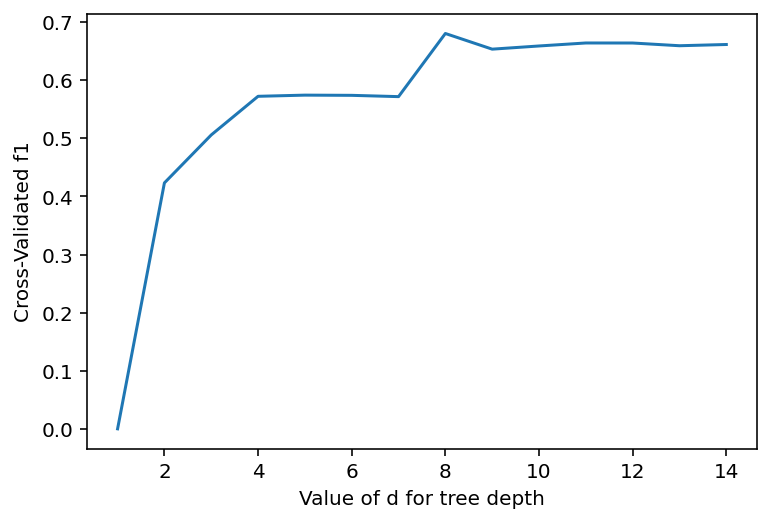

In [122]:
plt.plot(d_range, t_scores)
plt.xlabel('Value of d for tree depth')
plt.ylabel('Cross-Validated f1');

In [123]:
tree = DecisionTreeClassifier(max_depth=8)
tscores = cross_val_score(tree, pd.get_dummies(X_tr), y_tr, cv=10, scoring='f1')
print(tscores.mean())

0.6802911204387522


In [124]:
tree = DecisionTreeClassifier(max_depth=8)
tree.fit(pd.get_dummies(X_train), y_train)
log_loss(y_val, tree.predict_proba(pd.get_dummies(X_val)))

0.13312383688008803

In [125]:
from sklearn.ensemble import RandomForestClassifier
r_forest = RandomForestClassifier(n_estimators=100)
r_forest.fit(pd.get_dummies(X_train), y_train)
ry_pred = r_forest.predict(pd.get_dummies(X_val))
f1_score(y_val, ry_pred)

0.6234173399252382

In [126]:
log_loss(y_val, r_forest.predict_proba(pd.get_dummies(X_val)))

0.4200830665675743

In [127]:
from sklearn.inspection import permutation_importance
tree = DecisionTreeClassifier(max_depth=8)
tree.fit(pd.get_dummies(X_train), y_train)
features_imp = permutation_importance(tree, pd.get_dummies(X_val), y_val, scoring = 'f1', n_jobs = -1)

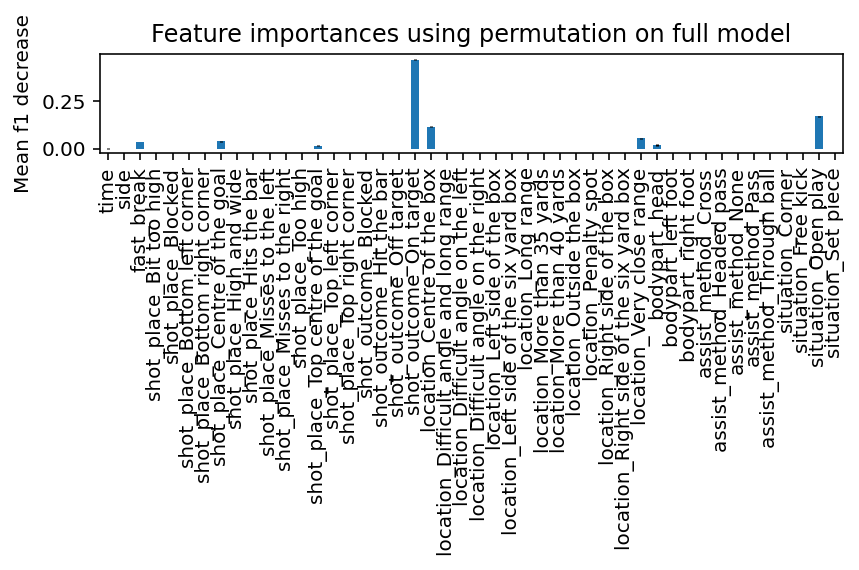

In [128]:
tree_importances = pd.Series(features_imp.importances_mean, index=pd.get_dummies(X_train).columns)

fig, ax = plt.subplots()
tree_importances.plot.bar(yerr=features_imp.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean f1 decrease")
fig.tight_layout()
plt.show()

### Based on log loss, f1, and ability to interpret model features, I will look further into ran is the model I should go with, now onto feature engineering!

In [129]:
cleaned_att.columns

Index(['time', 'event_type', 'event_type2', 'side', 'event_team', 'opponent',
       'player', 'player2', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

In [7]:
near_or_far = []
for p, l in zip(cleaned_att['shot_place'], cleaned_att['location']):
    if 'left' in p.lower() and 'left' in l.lower():
        near_or_far.append("Near post")
    elif 'right' in p.lower() and 'right' in l.lower():
        near_or_far.append("Near post")
    elif 'left' in p.lower() and 'right' in l.lower():
        near_or_far.append("Far post")
    elif 'right' in p.lower() and 'left' in l.lower():
        near_or_far.append("Far post")
    else:
        near_or_far.append(NaN)

In [8]:
len(near_or_far)

226676

In [9]:
cleaned_att['Near_or_far_post'] = near_or_far
cleaned_att.head()

,time,event_type,event_type2,side,event_team,opponent,player,player2,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,Near_or_far_post
0,2,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,High and wide,Off target,0,Left side of the box,left foot,Pass,Open play,0,NaN
1,14,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,mario gotze,Top right corner,Off target,0,Outside the box,right foot,Pass,Open play,0,NaN
2,17,1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,Bottom right corner,On target,1,Left side of the box,left foot,Pass,Open play,0,Far post
3,19,1,NaN,1,Borussia Dortmund,Hamburg SV,mats hummels,NaN,Blocked,Blocked,0,Outside the box,right foot,None,Open play,0,NaN
4,20,1,NaN,2,Hamburg SV,Borussia Dortmund,tomas rincon,NaN,Blocked,Blocked,0,Outside the box,right foot,None,Open play,0,NaN


In [10]:
columns_ = columns+['Near_or_far_post']
X = cleaned_att.loc[:, columns_]
y = cleaned_att['is_goal']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=9)

In [134]:
from sklearn.metrics import roc_auc_score, roc_curve
tree = DecisionTreeClassifier(max_depth=8)
tree.fit(pd.get_dummies(X_train), y_train)
fpr, tpr, thresholds = roc_curve(y_val, tree.predict_proba(pd.get_dummies(X_val))[:,1])


ROC AUC score =  0.960419037710504


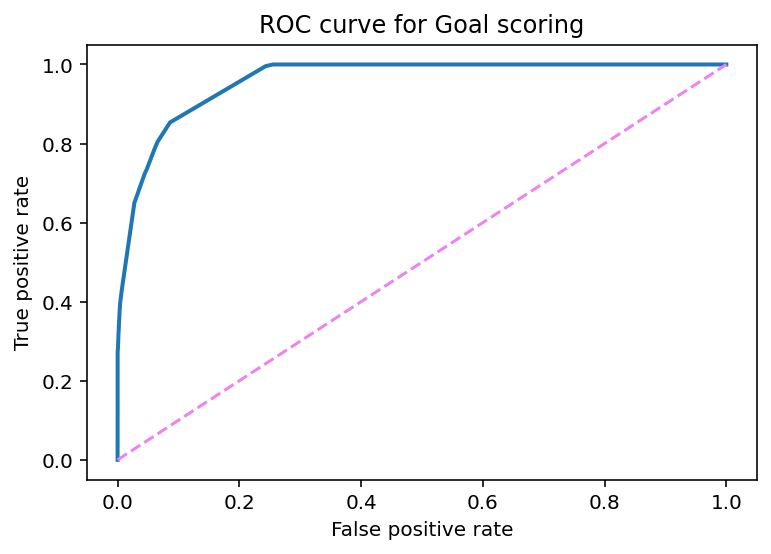

In [135]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Goal scoring');
print("ROC AUC score = ", roc_auc_score(y_val, tree.predict_proba(pd.get_dummies(X_val))[:,1]))

In [11]:
negative_indices = cleaned_att[cleaned_att.is_goal == 0].index
sample_size = len(cleaned_att[cleaned_att.is_goal == 1])
random_indices = np.random.choice(negative_indices, sample_size, replace=False)
undersampled = cleaned_att.loc[random_indices]
undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21995 entries, 64461 to 167201
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              21995 non-null  int64  
 1   event_type        21995 non-null  int64  
 2   event_type2       16219 non-null  float64
 3   side              21995 non-null  int64  
 4   event_team        21995 non-null  object 
 5   opponent          21995 non-null  object 
 6   player            21995 non-null  object 
 7   player2           16211 non-null  object 
 8   shot_place        21995 non-null  object 
 9   shot_outcome      21995 non-null  object 
 10  is_goal           21995 non-null  int64  
 11  location          21995 non-null  object 
 12  bodypart          21995 non-null  object 
 13  assist_method     21995 non-null  object 
 14  situation         21995 non-null  object 
 15  fast_break        21995 non-null  int64  
 16  Near_or_far_post  2217 non-null   o

In [12]:
positive_indices = cleaned_att[cleaned_att.is_goal == 1].index
goals = cleaned_att.loc[positive_indices]
goals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21995 entries, 2 to 227438
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              21995 non-null  int64  
 1   event_type        21995 non-null  int64  
 2   event_type2       15847 non-null  float64
 3   side              21995 non-null  int64  
 4   event_team        21995 non-null  object 
 5   opponent          21995 non-null  object 
 6   player            21995 non-null  object 
 7   player2           15842 non-null  object 
 8   shot_place        21995 non-null  object 
 9   shot_outcome      21995 non-null  object 
 10  is_goal           21995 non-null  int64  
 11  location          21995 non-null  object 
 12  bodypart          21995 non-null  object 
 13  assist_method     21995 non-null  object 
 14  situation         21995 non-null  object 
 15  fast_break        21995 non-null  int64  
 16  Near_or_far_post  3362 non-null   objec

In [13]:
balanced = pd.concat([goals, undersampled])

X_bal = balanced.loc[:, columns_]
y_bal = balanced['is_goal']
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(X_bal, y_bal, test_size=0.2, random_state=10)
Xb_train, Xb_val, yb_train, yb_val = train_test_split(Xb_tr, yb_tr, test_size=0.25, random_state=9)

In [140]:
db_range = list(range(1, 15))
tb_scores = []

for d in db_range:
    tree = DecisionTreeClassifier(max_depth=d)
    tscores = cross_val_score(tree, pd.get_dummies(Xb_tr), yb_tr, cv=10, scoring='f1')
    tb_scores.append(tscores.mean())

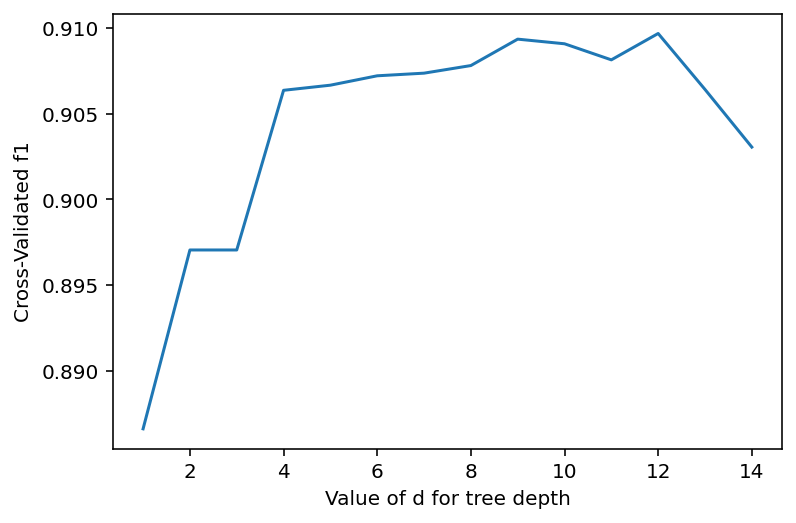

In [141]:
plt.plot(db_range, tb_scores)
plt.xlabel('Value of d for tree depth')
plt.ylabel('Cross-Validated f1');

In [149]:
tree = DecisionTreeClassifier(max_depth=12)
tbscores = cross_val_score(tree, pd.get_dummies(Xb_tr), yb_tr, cv=10, scoring='f1')
print(tbscores.mean())

0.9097490688311346


.909 is a significant improvement on f1 from .69, will also look if balancingf the model is any better than using 50/50 split data

In [143]:
tree = DecisionTreeClassifier(max_depth=8, class_weight = 'balanced')
tscores = cross_val_score(tree, pd.get_dummies(X_tr), y_tr, cv=10, scoring='f1')
print(tscores.mean())


0.5354386112613784


In [144]:
tree = DecisionTreeClassifier(max_depth=8, class_weight = 'balanced')
tree = tree.fit(pd.get_dummies(X_tr), y_tr)
ytb_pred = tree.predict(pd.get_dummies(X_te))
f1_score(y_te, ytb_pred)

0.5376316629428664

we will use a feature engineered, undersampled data set as our training set to then predict on the test (holdout) set

In [150]:
tree = DecisionTreeClassifier(max_depth=12)
tree = tree.fit(pd.get_dummies(Xb_tr), yb_tr)
ytb_pred = tree.predict(pd.get_dummies(X_te))
f1_score(y_te, ytb_pred)

0.5521064301552107

In [151]:
fpr, tpr, thresholds = roc_curve(y_te, tree.predict_proba(pd.get_dummies(X_te))[:,1])


ROC AUC score =  0.9654011989901624


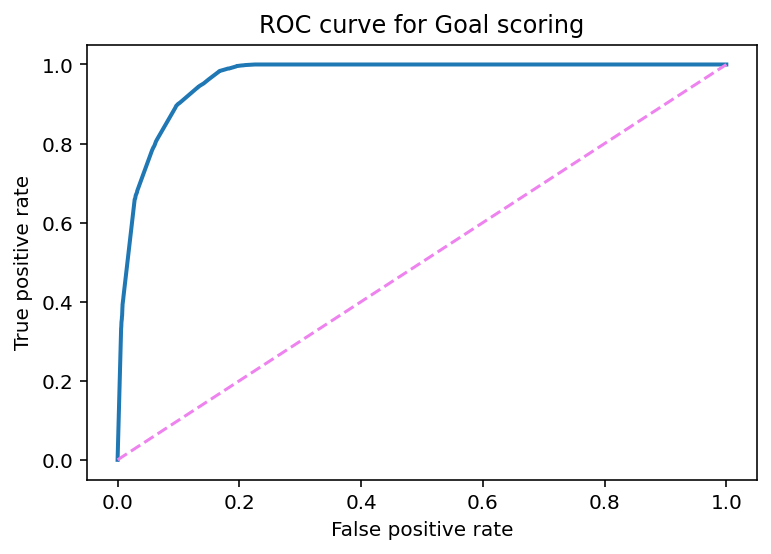

In [152]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Goal scoring');
print("ROC AUC score = ", roc_auc_score(y_te, tree.predict_proba(pd.get_dummies(X_te))[:,1]))

In [153]:
tree = DecisionTreeClassifier(max_depth=12)
tree.fit(pd.get_dummies(Xb_tr), yb_tr)
log_loss(y_te, tree.predict_proba(pd.get_dummies(X_te)))

0.41603276524636745

In [154]:
importances = []
index_ = []
for f,i in zip(tree.feature_importances_, pd.get_dummies(Xb_train).columns):
    if f > 0.009:
        importances.append(f)
        index_.append(i)
        
print((index_, importances))

(['time', 'fast_break', 'shot_place_Centre of the goal', 'shot_place_Top centre of the goal', 'shot_outcome_On target', 'location_Outside the box', 'location_Very close range', 'situation_Open play'], [0.009335699698690872, 0.012360067091804875, 0.030691815684853713, 0.04531892273832337, 0.7899741877902191, 0.03572447581051881, 0.009149683192096135, 0.02068787622185154])


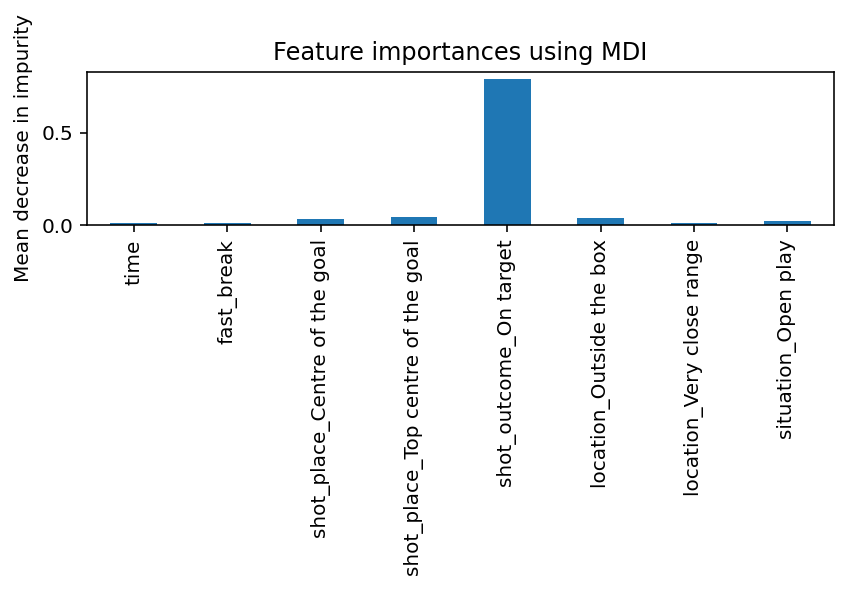

In [155]:
tree_importances = pd.Series(importances, index=index_)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
lr = LogisticRegression(solver='lbfgs', max_iter=5000)
scores = cross_val_score(lr, pd.get_dummies(Xb_tr), yb_tr, cv=10, scoring='f1')
print(scores.mean())

0.9095522943304605


In [22]:
cl = [.01, .1, 1, 10, 100, 1000]
s = []
for c in cl: 
    lr = LogisticRegression(solver='lbfgs', max_iter=5000, C = c)
    lr.fit(pd.get_dummies(X_train), y_train)
    y_pred = lr.predict(pd.get_dummies(X_val))
    s.append(f1_score(y_val, y_pred))
s

[0.5893921334922526,
 0.6559068659875646,
 0.6664108467638783,
 0.668364099299809,
 0.6692111959287532,
 0.6695464362850971]

In [24]:
for c in cl:
    lr = LogisticRegression(solver='lbfgs', max_iter=5000, C=c)
    scores = cross_val_score(lr, pd.get_dummies(Xb_tr), yb_tr, cv=10, scoring='f1')
    print(scores.mean())
#.909 with C = 1

0.9074511885663471
0.9094405198525152
0.9095522943304605
0.9095791873199209
0.9097829536516319
0.9097241567199467


In [18]:
lr = LogisticRegression(solver='lbfgs', max_iter=5000, C=100, class_weight = 'balanced')
scores = cross_val_score(lr, pd.get_dummies(X_tr), y_tr, cv=10, scoring='f1')
print(scores.mean())

0.5565854379915072


In [31]:
lr = LogisticRegression(solver='lbfgs', max_iter=5000, C=100)
lr.fit(pd.get_dummies(Xb_tr), yb_tr)
yb_pred = lr.predict(pd.get_dummies(X_te))
f1_score(y_te, yb_pred)

0.5602841632598352

In [26]:
log_loss(y_te, lr.predict_proba(pd.get_dummies(X_te)))

0.23776581411326422

In [21]:
d = {}
coef_lst = lr.coef_.tolist()
for c, v in zip(pd.get_dummies(Xb_tr).columns, coef_lst[0]):
    d[c] = v
d

{'time': 0.0007353903935902374,
 'side': -0.0680191416172119,
 'fast_break': 4.474916234808435,
 'shot_place_Bit too high': -0.3905032371426983,
 'shot_place_Blocked': -1.1438484621506568,
 'shot_place_Bottom left corner': 2.0696000905904812,
 'shot_place_Bottom right corner': 1.930003398332483,
 'shot_place_Centre of the goal': 0.35994238708238907,
 'shot_place_High and wide': -0.5453656351441584,
 'shot_place_Hits the bar': -1.6106907420847265,
 'shot_place_Misses to the left': -0.9309022631461212,
 'shot_place_Misses to the right': -0.8678847683790389,
 'shot_place_Too high': -0.7255674698118435,
 'shot_place_Top centre of the goal': -4.158491088339839,
 'shot_place_Top left corner': 2.419109802629885,
 'shot_place_Top right corner': 2.309939007512881,
 'shot_outcome_Blocked': -1.1438484621506568,
 'shot_outcome_Hit the bar': -1.6106907420847265,
 'shot_outcome_Off target': -4.387899391412595,
 'shot_outcome_On target': 5.857779615593731,
 'location_Centre of the box': 1.07482386147

In [160]:
sort_coefs = sorted(d.items(), key=lambda x: x[1], reverse=True)
for itemsort_coefs

[('shot_outcome_On target', 5.908841145381646),
 ('fast_break', 4.472687227366703),
 ('location_Very close range', 3.115365981920674),
 ('shot_place_Top right corner', 2.467069109243979),
 ('shot_place_Top left corner', 2.2763345332769824),
 ('location_Right side of the six yard box', 2.049599316006841),
 ('shot_place_Bottom left corner', 1.9055585283150014),
 ('shot_place_Bottom right corner', 1.8655890210756987),
 ('location_Left side of the six yard box', 1.772624238439102),
 ('situation_Corner', 1.397118502661444),
 ('situation_Set piece', 1.0967810562698008),
 ('location_Centre of the box', 1.0718980419240214),
 ('assist_method_Through ball', 0.5163354926755519),
 ('shot_place_Centre of the goal', 0.3160826767607074),
 ('location_Difficult angle on the left', 0.22855860344522927),
 ('Near_or_far_post_Far post', 0.11775880548220553),
 ('location_Difficult angle on the right', 0.08704064285958586),
 ('bodypart_right foot', 0.03192737387220803),
 ('bodypart_left foot', 0.010262640883

Text(0.5, 1.0, 'Largest Logistic Regression Coeffiecents')

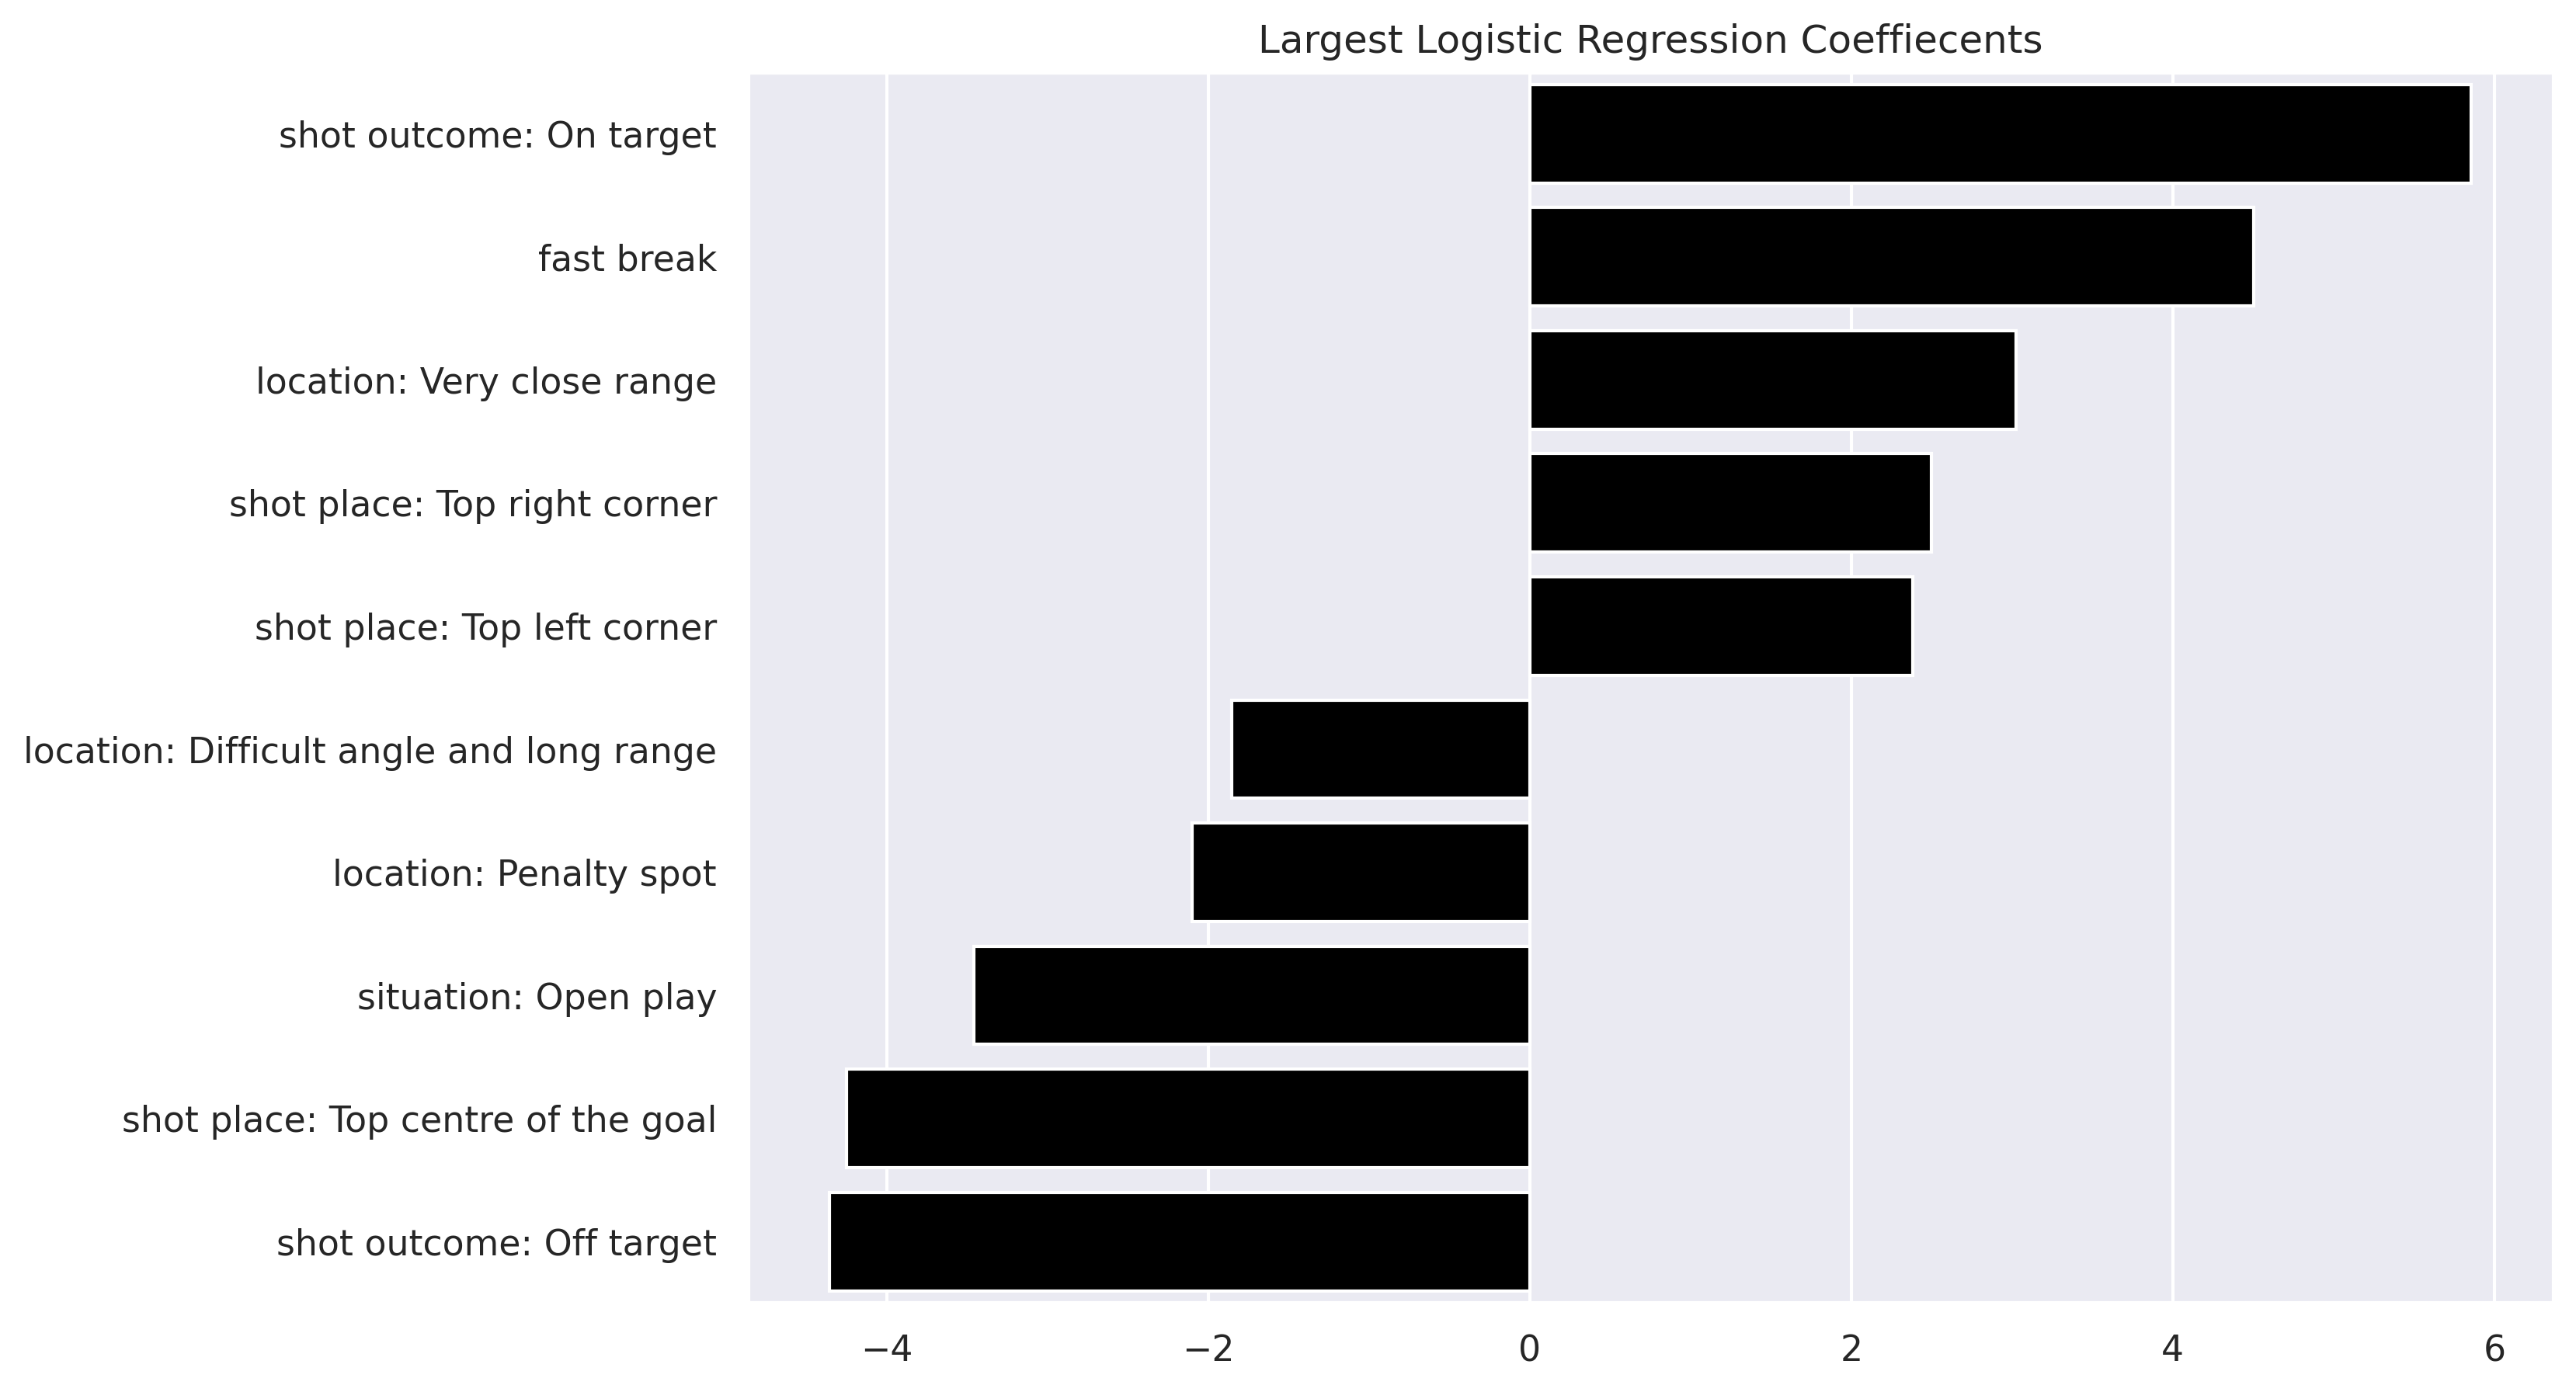

In [17]:
sns.set(rc={'figure.figsize':(10,7)})
plt.figure(dpi=150)
ax = sns.barplot(x=[5.855769994524262, 4.50061408532211, 3.0235922976975473, 2.5003361519134706,2.3840062387727707,-1.8562421350100304,\
               -2.1012112940422316,-3.4600172926044053,-4.25265971625283,-4.354729840893653], y = ['shot outcome: On target','fast break',\
    'location: Very close range','shot place: Top right corner','shot place: Top left corner','location: Difficult angle and long range',\
  'location: Penalty spot','situation: Open play','shot place: Top centre of the goal','shot outcome: Off target'], color='black')
ax.set_title('Largest Logistic Regression Coeffiecents')

Text(0.5, 1.0, 'lr confusion matrix')

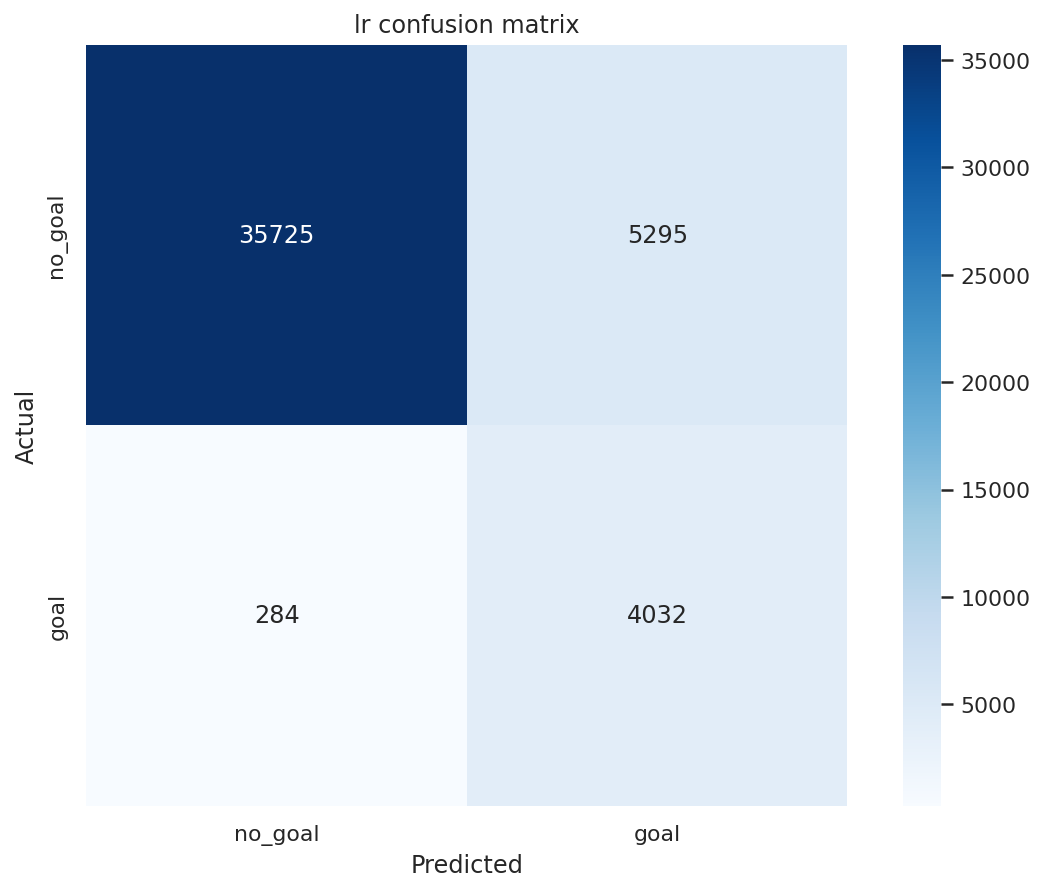

In [48]:
y_predict = (lr.predict_proba(pd.get_dummies(X_te))[:, 1] >= .56)
lr_confusion = confusion_matrix(y_te, y_predict)
lr_confusion
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, fmt='d', square=True,
           xticklabels=['no_goal','goal'],
           yticklabels=['no_goal','goal']);

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('lr confusion matrix')

In [47]:
f1_score(y_te, y_predict)

0.5602841632598352

In [161]:
lr.fit(pd.get_dummies(Xb_tr), yb_tr)
fpr, tpr, thresholds = roc_curve(y_te, lr.predict_proba(pd.get_dummies(X_te))[:,1])


ROC AUC score =  0.9652781351938904


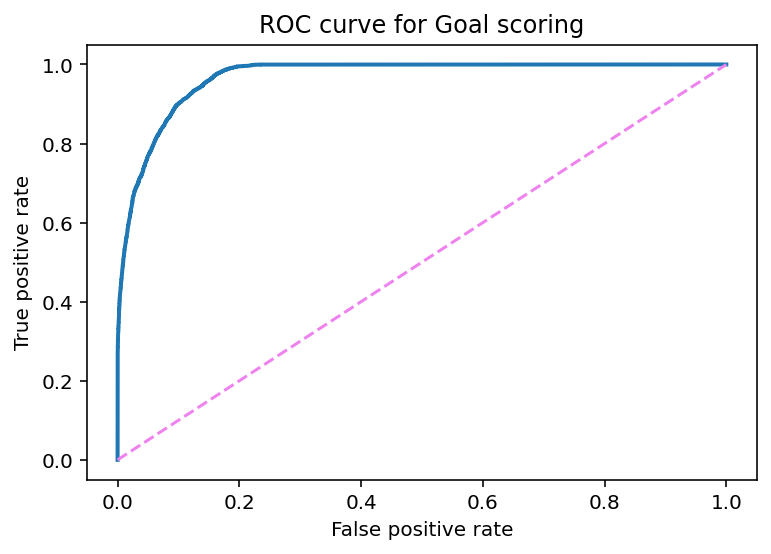

In [162]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Goal scoring');
print("ROC AUC score = ", roc_auc_score(y_te, tree.predict_proba(pd.get_dummies(X_te))[:,1]))

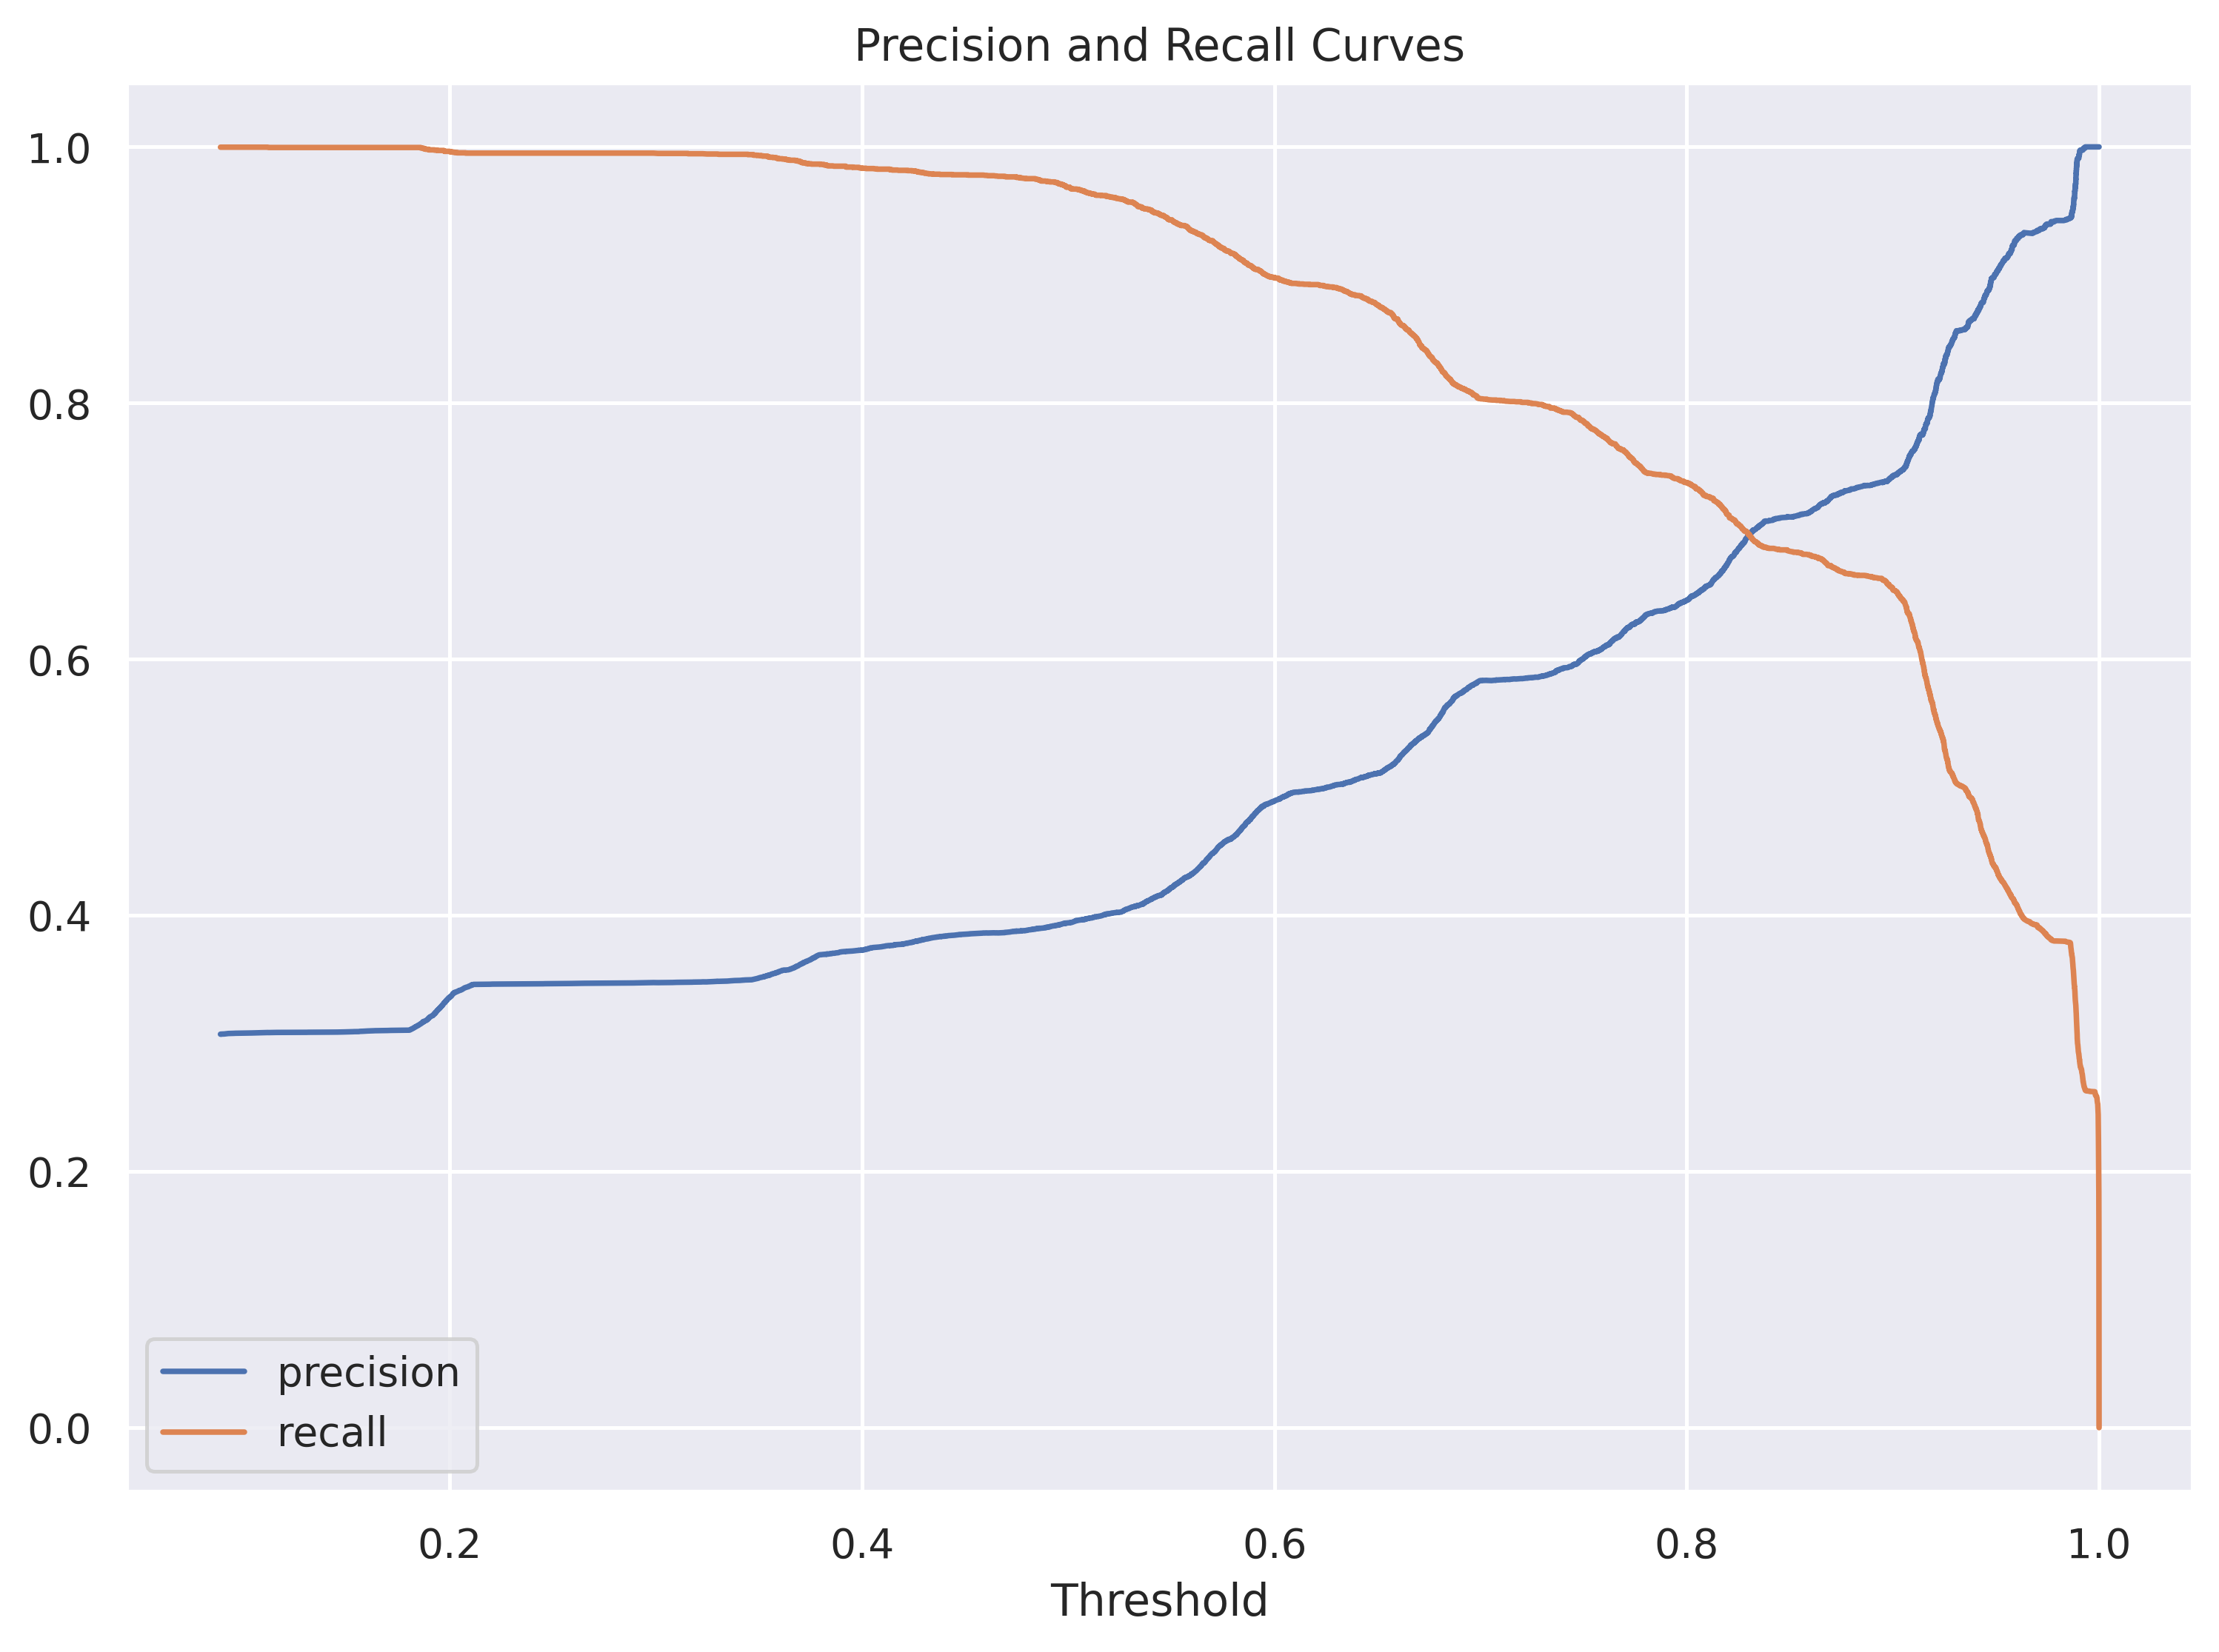

In [59]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, lr.predict_proba(pd.get_dummies(X_te))[:,1] )

plt.figure(dpi=180)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

Based on the numbers the logisitic model is what I will be presenting on!